 # Objectifs 
 
 - Premiere exploration des sources de données SAE https://www.sae-diffusion.sante.gouv.fr/
 - Mise en contexte avec les données du recencement
 - carto rapide avec contour départementaux
 
 En l'absence de connaissance métiers fines sur la signification des différents types de lits en réaniation, on se contente de les traiter en aggrégat

Wikipedia

> Une unité de soins intensifs (USI) est un service de l’hôpital qui prodigue des soins de suppléance à une défaillance aigüe. Elle est la structure médiane entre les services de réanimation (réa) et les unités de soins continus (USC), et prend en charge une défaillance unique sur une durée limitée. Elles constituent avec les USC les unités intermédiaires entre la réanimation et les services de soins généraux hospitaliers.

>Le service des soins intensifs a pour mission de prendre en charge les patients en état critique, c'est-à-dire qui présentent une défaillance d’une fonction vitale, ou qui sont à risque de développer une complication sévère. Le service dispose de moyens techniques très spécialisés. Ceux-ci sont mis en œuvre de façon continue par une équipe multidisciplinaire afin de déceler, prévenir et corriger les déséquilibres aigus et présumés réversibles liés à l’affection sous-jacente (maladie, chirurgie, traumatisme, intoxication).

In [200]:
from pathlib import Path
import os

In [201]:
import pandas as pd
import numpy as np 

In [202]:
import geopandas 
import shapefile
import matplotlib.pyplot as plt

In [203]:
%matplotlib inline

## Chargement des données

In [204]:
nomencl_path  = Path(r'SAE 2018 Bases statistiques - formats SAS-CSV/Documentation/Nomenclatures_2018.xls')

In [205]:
etab_path = Path('etablissement_finess.xlsx')

In [206]:
rea_path = Path(r'SAE 2018 Bases statistiques - formats SAS-CSV/Bases statistiques/Bases CSV/REA_2018r.csv')

In [207]:
capat_18 = Path(r'SAE 2018 Bases statistiques - formats SAS-CSV/Séries longues/Bases CSV/capact0018.csv')

In [208]:
var_path = Path(r"SAE 2018 Bases statistiques - formats SAS-CSV/Documentation/Liste variables SAE 2018.xlsx")

In [209]:
pop_path = Path(r'estim-pop-dep-sexe-gca-1975-2020.xls')

In [210]:
#pop_df = pd.read_excel(pop_path,skiprows=3,sheet_name='2020',header=[0,1])
pop_df = pd.read_excel(pop_path,skiprows=4,sheet_name='2020')

In [211]:
pop_df.head()

,Unnamed: 0,Unnamed: 1,0 à 19 ans,20 à 39 ans,40 à 59 ans,60 à 74 ans,75 ans et plus,Total,0 à 19 ans.1,20 à 39 ans.1,40 à 59 ans.1,60 à 74 ans.1,75 ans et plus.1,Total.1,0 à 19 ans.2,20 à 39 ans.2,40 à 59 ans.2,60 à 74 ans.2,75 ans et plus.2,Total.2
0,01,Ain,167666.0,151084.0,179469.0,104453.0,54283.0,656955.0,86596.0,75213.0,89272.0,50205.0,22059.0,323345.0,81070.0,75871.0,90197.0,54248.0,32224.0,333610.0
1,02,Aisne,129852.0,114042.0,135164.0,98046.0,48946.0,526050.0,66903.0,57238.0,67061.0,47243.0,18532.0,256977.0,62949.0,56804.0,68103.0,50803.0,30414.0,269073.0
2,03,Allier,66659.0,61490.0,85304.0,72079.0,45783.0,331315.0,34168.0,31287.0,41610.0,33574.0,17573.0,158212.0,32491.0,30203.0,43694.0,38505.0,28210.0,173103.0
3,04,Alpes-de-Haute-Provence,34281.0,30814.0,43423.0,35681.0,20998.0,165197.0,18016.0,15439.0,21116.0,17344.0,8697.0,80612.0,16265.0,15375.0,22307.0,18337.0,12301.0,84585.0
4,05,Hautes-Alpes,30280.0,27715.0,37829.0,29047.0,16885.0,141756.0,15665.0,13942.0,18692.0,14094.0,6838.0,69231.0,14615.0,13773.0,19137.0,14953.0,10047.0,72525.0


In [212]:
pop_df = pop_df.iloc[:,:8].rename(columns={"Unnamed: 0":'DEP',"Unnamed: 1":'DEP_NAME'})

In [213]:
var_df = pd.read_excel(var_path)

In [214]:
var_df.head()

,Table SAS,Variable SAS,Label variable SAS,Variable Modalité,Valeur Modalité,Label,Bordereau,Case du questionnaire
0,ID,BOR,Bordereau,NaN,NaN,NaN,(Var SAS),NaN
1,ID,AN,Année,NaN,NaN,NaN,(Var SAS),NaN
2,ID,FI,N° Finess,NaN,NaN,NaN,(Var SAS),NaN
3,ID,RS,Raison sociale de l'entité interrogée,NaN,NaN,NaN,ID1,ID1_A2
4,ID,RSCOM,Complément de raison sociale,NaN,NaN,NaN,ID1,ID1_A3


In [215]:
etab_df = pd.read_excel(etab_path,skiprows=4)
etab_df.head()

,FINESS,Raison sociale,Commune,Statut Juridique,Région
0,010000024,010000024 - CENTRE HOSPITALIER DE FLEYRIAT,BOURG-EN-BRESSE,Public,84 - Auvergne-Rhône-Alpes
1,010000032,010000032 - CENTRE HOSPITALIER DE BELLEY,BELLEY,Public,84 - Auvergne-Rhône-Alpes
2,010000065,010000065 - CH DE TREVOUX - MONTPENSIER,TREVOUX,Public,84 - Auvergne-Rhône-Alpes
3,010000081,010000081 - CENTRE HOSPITALIER DU PAYS DE GEX,GEX,Public,84 - Auvergne-Rhône-Alpes
4,010000099,010000099 - CENTRE HOSPITALIER DE MEXIMIEUX,MEXIMIEUX,Public,84 - Auvergne-Rhône-Alpes


In [216]:
etab_df.FINESS.unique().shape

(4032,)

In [217]:
rea_df = pd.read_csv(rea_path,sep=';')
rea_df.head()

,BOR,AN,FI,FI_EJ,UNI,LIT,JLI,SEJ,PAS,PAS0,...,ETP_INFNS,EFFPL_AID,EFFPA_AID,ETP_AID,EFFPL_KINE,EFFPA_KINE,ETP_KINE,EFFPL_APNM,EFFPA_APNM,ETP_APNM
0,REA,2018,010000024,010780054,REAADU,12.0,4380.0,961,1023.0,102.0,...,27.47,14.0,6.0,16.36,NaN,NaN,NaN,1.0,NaN,1.0
1,REA,2018,010000024,010780054,SITOT,4.0,3024.0,822,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,REA,2018,010000024,010780054,SIUNV,4.0,1460.0,458,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,REA,2018,010000024,010780054,SURVADU,6.0,2190.0,541,NaN,NaN,...,7.07,8.0,1.0,6.62,NaN,NaN,NaN,NaN,NaN,NaN
4,REA,2018,010000024,010780054,SURVENF,4.0,1460.0,342,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
cap_df = pd.read_csv(capat_18,sep=';',encoding='latin-1')
cap_df.head()

,fi,an,fi_ej,rs,stj,cat,dep,reg,anc_reg,espic,...,LIT,SEJHC,JOU,PLA,SEJHP,PAS,SEJACC,SEHEM,SERAD,SECHI
0,10000495,2005,1.0783e+07,C.P.A. BOURG EN BRESSE,61.0,292.0,1,84.0,82.0,NaN,...,424.0,4283.0,145112.0,109.0,20943.0,NaN,NaN,NaN,NaN,NaN
1,10000495,2010,1.0783e+07,C.P.A. BOURG EN BRESSE,61.0,292.0,1,84.0,82.0,NaN,...,409.0,6781.0,135981.0,124.0,42635.0,NaN,NaN,NaN,NaN,NaN
2,10000495,2011,1.0783e+07,C.P.A. BOURG EN BRESSE,61.0,292.0,1,84.0,82.0,NaN,...,386.0,6327.0,134649.0,124.0,18518.0,NaN,NaN,NaN,NaN,NaN
3,10000495,2012,1.0783e+07,C.P.A. BOURG EN BRESSE,61.0,292.0,1,84.0,82.0,6.0,...,386.0,6021.0,134222.0,124.0,18875.0,NaN,NaN,NaN,NaN,NaN
4,10000495,2013,1.0783e+07,C.P.A. BOURG EN BRESSE,61.0,292.0,1,84.0,82.0,6.0,...,371.0,6463.0,131801.0,124.0,17576.0,NaN,NaN,NaN,NaN,NaN


In [221]:
cap_df.columns

Index(['fi', 'an', 'fi_ej', 'rs', 'stj', 'cat', 'dep', 'reg', 'anc_reg',
       'espic', 'cominsee', 'grp', 'DISCI', 'DISCIPLINE', 'LIT', 'SEJHC',
       'JOU', 'PLA', 'SEJHP', 'PAS', 'SEJACC', 'SEHEM', 'SERAD', 'SECHI'],
      dtype='object')

In [222]:
cap_df.dep.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       21, 22, 23, 24, 25, 26, 27, 28, 29, '29', '2A', '2B', '30', '31',
       '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42',
       '43', '44', '45', '46', '47', nan, '48', '49', '50', 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0,
       81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0,
       92.0, '92', '93', '94', '95', '9A', '9B', '9C', '9D', '9F'],
      dtype=object)

 Le numéro finess qui peremt d'identifier un établissement de santé

In [224]:
rea_df.FI.unique().shape

(812,)

In [225]:
rea_df.UNI.unique()

array(['REAADU', 'SITOT', 'SIUNV', 'SURVADU', 'SURVENF', 'USIC', 'AUTSI',
       'REAENF'], dtype=object)

In [237]:
# chargement des coutours dépertementaux OSM 
gdf = geopandas.read_file('departements-20140306-100m.shp')
gdf.tail(10)

,code_insee,nom,nuts3,wikipedia,geometry
91,91,Essonne,FR104,b'fr:Essonne (d\xe9partement)',"POLYGON ((2.392328496135124 48.33592916158408,..."
92,92,Hauts-de-Seine,FR105,fr:Hauts-de-Seine,"POLYGON ((2.319926260528716 48.7707501725293, ..."
93,93,Seine-Saint-Denis,FR106,fr:Seine-Saint-Denis,"POLYGON ((2.418994715849627 48.84938657374529,..."
94,94,Val-de-Marne,FR107,fr:Val-de-Marne,"POLYGON ((2.414497659705796 48.71780178979385,..."
95,95,Val-d'Oise,FR108,fr:Val-d'Oise,"POLYGON ((1.796736299947983 49.07195815991548,..."
96,971,Guadeloupe,FR910,fr:Guadeloupe,(POLYGON ((-61.61402941320713 15.8395477602560...
97,972,Martinique,FR920,fr:Martinique,(POLYGON ((-60.86880349267127 14.3909057613284...
98,973,Guyane,FR930,fr:Guyane,(POLYGON ((-52.58463013337558 5.28309137731124...
99,974,b'La R\xe9union',FR940,b'fr:La R\xe9union',(POLYGON ((55.77885611721816 -21.3629143474847...
100,976,Mayotte,None,fr:Mayotte,(POLYGON ((45.13666936665152 -13.0039774513961...


In [238]:
# Conversion en Lambert 93 et filtrage sur France Métropolitaine 

In [239]:
gdf = gdf.to_crs(2154)

In [240]:
gdf = gdf[:96]

# Croisements

In [226]:
# jointure sur les établissements
rea_df = pd.merge(rea_df,etab_df,left_on='FI',right_on='FINESS')

In [234]:
rea_df.head()

,BOR,AN,FI,FI_EJ,UNI,LIT,JLI,SEJ,PAS,PAS0,...,ETP_KINE,EFFPL_APNM,EFFPA_APNM,ETP_APNM,FINESS,Raison sociale,Commune,Statut Juridique,Région,DEP
0,REA,2018,010000024,010780054,REAADU,12.0,4380.0,961,1023.0,102.0,...,NaN,1.0,NaN,1.0,010000024,010000024 - CENTRE HOSPITALIER DE FLEYRIAT,BOURG-EN-BRESSE,Public,84 - Auvergne-Rhône-Alpes,01
1,REA,2018,010000024,010780054,SITOT,4.0,3024.0,822,NaN,NaN,...,NaN,NaN,NaN,NaN,010000024,010000024 - CENTRE HOSPITALIER DE FLEYRIAT,BOURG-EN-BRESSE,Public,84 - Auvergne-Rhône-Alpes,01
2,REA,2018,010000024,010780054,SIUNV,4.0,1460.0,458,NaN,NaN,...,NaN,NaN,NaN,NaN,010000024,010000024 - CENTRE HOSPITALIER DE FLEYRIAT,BOURG-EN-BRESSE,Public,84 - Auvergne-Rhône-Alpes,01
3,REA,2018,010000024,010780054,SURVADU,6.0,2190.0,541,NaN,NaN,...,NaN,NaN,NaN,NaN,010000024,010000024 - CENTRE HOSPITALIER DE FLEYRIAT,BOURG-EN-BRESSE,Public,84 - Auvergne-Rhône-Alpes,01
4,REA,2018,010000024,010780054,SURVENF,4.0,1460.0,342,NaN,NaN,...,NaN,NaN,NaN,NaN,010000024,010000024 - CENTRE HOSPITALIER DE FLEYRIAT,BOURG-EN-BRESSE,Public,84 - Auvergne-Rhône-Alpes,01


In [235]:
# Lits en Corse
rea_df[rea_df.FI.str.startswith('2A')|rea_df.FI.str.startswith('2B')]

,BOR,AN,FI,FI_EJ,UNI,LIT,JLI,SEJ,PAS,PAS0,...,ETP_KINE,EFFPL_APNM,EFFPA_APNM,ETP_APNM,FINESS,Raison sociale,Commune,Statut Juridique,Région,DEP
463,REA,2018,2A0000022,2A0000014,REAADU,10.0,3650.0,406,422.0,32.0,...,NaN,9.0,NaN,9.00,2A0000022,2A0000022 - CH ND LA MISERICORDE,AJACCIO,Public,94 - Corse,2A
464,REA,2018,2A0000022,2A0000014,SITOT,11.0,4015.0,922,NaN,NaN,...,NaN,NaN,NaN,NaN,2A0000022,2A0000022 - CH ND LA MISERICORDE,AJACCIO,Public,94 - Corse,2A
465,REA,2018,2A0000022,2A0000014,SIUNV,3.0,1095.0,208,NaN,NaN,...,NaN,NaN,NaN,NaN,2A0000022,2A0000022 - CH ND LA MISERICORDE,AJACCIO,Public,94 - Corse,2A
466,REA,2018,2A0000022,2A0000014,SURVADU,5.0,1825.0,426,NaN,NaN,...,NaN,4.0,NaN,4.00,2A0000022,2A0000022 - CH ND LA MISERICORDE,AJACCIO,Public,94 - Corse,2A
467,REA,2018,2A0000022,2A0000014,USIC,8.0,2920.0,714,NaN,NaN,...,NaN,0.0,NaN,0.00,2A0000022,2A0000022 - CH ND LA MISERICORDE,AJACCIO,Public,94 - Corse,2A
468,REA,2018,2A0000139,2A0000063,SURVADU,8.0,2920.0,401,NaN,NaN,...,NaN,2.0,NaN,2.00,2A0000139,2A0000139 - CLINISUD,AJACCIO,Privé lucratif,94 - Corse,2A
469,REA,2018,2A0000154,2A0000204,AUTSI,4.0,1460.0,209,NaN,NaN,...,1.0,NaN,1.0,0.50,2A0000154,2A0000154 - CLINIQUE DU SUD DE LA CORSE,PORTO-VECCHIO,Privé lucratif,94 - Corse,2A
470,REA,2018,2A0000154,2A0000204,SITOT,4.0,1460.0,209,NaN,NaN,...,NaN,NaN,NaN,NaN,2A0000154,2A0000154 - CLINIQUE DU SUD DE LA CORSE,PORTO-VECCHIO,Privé lucratif,94 - Corse,2A
471,REA,2018,2B0000012,2B0000020,REAADU,8.0,2920.0,303,309.0,14.0,...,0.0,4.0,3.0,4.89,2B0000012,2B0000012 - CENTRE HOSPITALIER DE BASTIA,BASTIA,Public,94 - Corse,2B
472,REA,2018,2B0000012,2B0000020,SITOT,6.0,2190.0,760,NaN,NaN,...,NaN,NaN,NaN,NaN,2B0000012,2B0000012 - CENTRE HOSPITALIER DE BASTIA,BASTIA,Public,94 - Corse,2B


In [236]:
rea_df['DEP'] = rea_df.FI.str[:2]

In [241]:
# Aggrégation départementale
rea_dep = rea_df.groupby('DEP').LIT.sum()

In [242]:
# Jointure avec la population 
rea_dep = pd.merge(rea_dep,pop_df,left_index=True,right_on='DEP')

In [243]:
# Ration pour 100k habitants
rea_dep['ratio'] = rea_dep.eval('LIT/Total*1e5')

In [244]:
gdf = gdf.rename(columns = {'code_insee':'DEP'})#.head()

In [245]:
# Jointure avec les contours
gdf = gdf.join(rea_dep.set_index('DEP'),on='DEP')

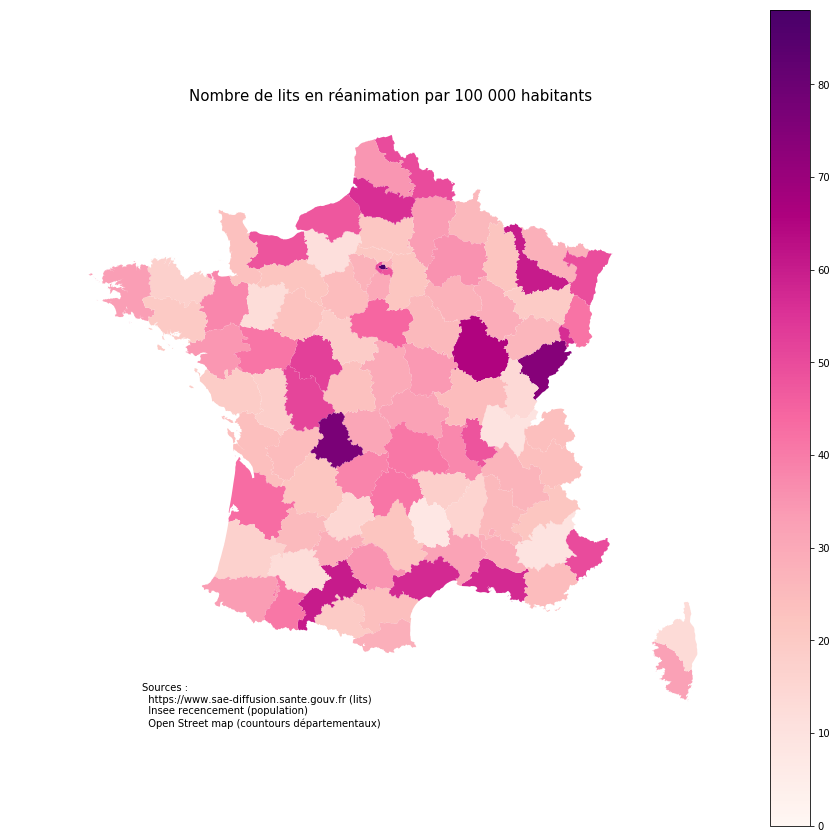

In [247]:
ax= gdf.plot(column='ratio',cmap='RdPu',legend=True,figsize=[15,15],vmin=0)
ax.set_title('Nombre de lits en réanimation par 100 000 habitants ',fontdict={'fontsize':15})
plt.axis('off')
ax.text(x=200000,y=6000000,s='Sources : \n  https://www.sae-diffusion.sante.gouv.fr (lits) \n  Insee recencement (population) \n  Open Street map (countours départementaux)')
ax.figure.savefig('lit_ratio.png',dpi=150)

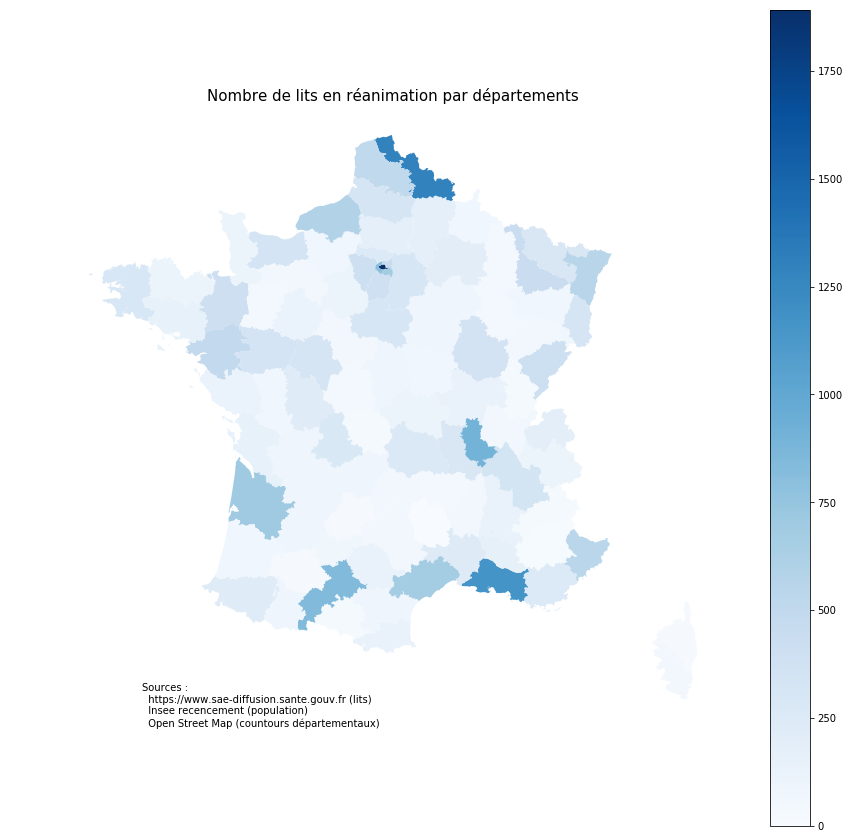

In [248]:
ax= gdf.plot(column='LIT',cmap='Blues',legend=True,figsize=[15,15],vmin=0)
ax.set_title('Nombre de lits en réanimation par départements',fontdict={'fontsize':15})
plt.axis('off')
ax.text(x=200000,y=6000000,s='Sources : \n  https://www.sae-diffusion.sante.gouv.fr (lits) \n  Insee recencement (population) \n  Open Street Map (countours départementaux)')
ax.figure.savefig('lit_DEP.png',dpi=150)